In [1]:
import pandas as pd
import os
from openpyxl import load_workbook
from functools import reduce

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

In [3]:
merged_df = pd.read_parquet("../../data/merged_era5data/merged_df_bhutan_time.parquet")

### Check some basic information

In [4]:
# Basic info
merged_df.info()

# Descriptive statistics
merged_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032800 entries, 0 to 5032799
Data columns (total 8 columns):
 #   Column          Dtype                       
---  ------          -----                       
 0   latitude        float64                     
 1   longitude       float64                     
 2   datetime        datetime64[ns, Asia/Thimphu]
 3   temperature     float64                     
 4   wind_u          float64                     
 5   wind_v          float64                     
 6   precipitation   float64                     
 7   surface_runoff  float64                     
dtypes: datetime64[ns, Asia/Thimphu](1), float64(7)
memory usage: 307.2 MB


,latitude,longitude,temperature,wind_u,wind_v,precipitation,surface_runoff
count,5.032800e+06,5.032800e+06,5.032800e+06,5.032800e+06,5.032800e+06,5.032800e+06,5.032800e+06
mean,2.750000e+01,9.025000e+01,8.927683e+00,2.320194e-02,4.330372e-01,3.025644e-04,1.330065e-04
std,6.454973e-01,1.080124e+00,1.232783e+01,9.392996e-01,1.245680e+00,8.376649e-04,5.415404e-04
min,2.650000e+01,8.850000e+01,-3.707571e+01,-9.859543e+00,-1.005762e+01,0.000000e+00,0.000000e+00
25%,2.700000e+01,8.925000e+01,3.092346e-01,-4.715576e-01,-5.536804e-01,9.536743e-07,0.000000e+00
50%,2.750000e+01,9.025000e+01,8.930359e+00,-1.603699e-02,4.000397e-01,3.337860e-05,9.536743e-07
75%,2.800000e+01,9.125000e+01,1.864200e+01,4.651337e-01,1.310776e+00,2.393723e-04,4.911423e-05
max,2.850000e+01,9.200000e+01,3.969839e+01,1.070552e+01,1.003264e+01,3.796482e-02,3.309250e-02


### View correlation between variables

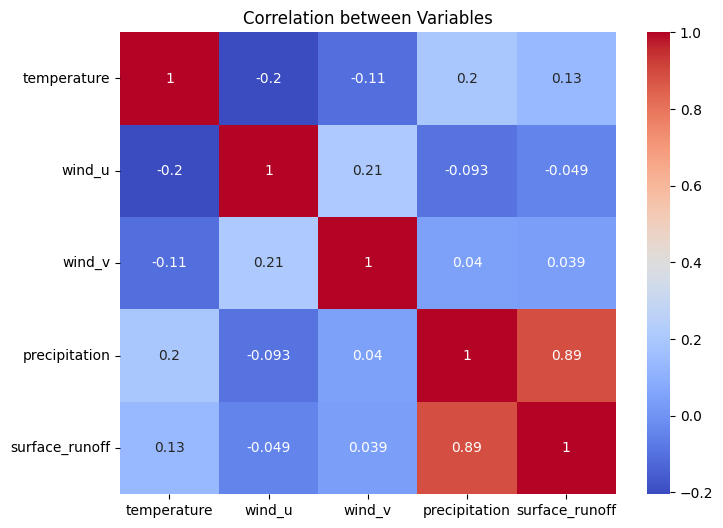

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df[["temperature", "wind_u", "wind_v", "precipitation", "surface_runoff"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between Variables")
plt.show()

### Check correlation for each spatial unit
- also tried using mutual information as a comparison

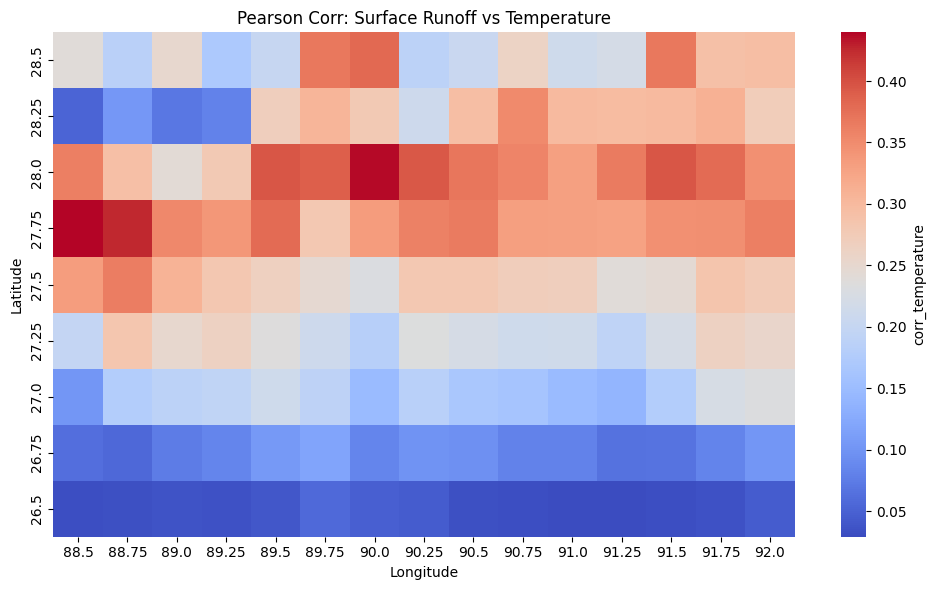

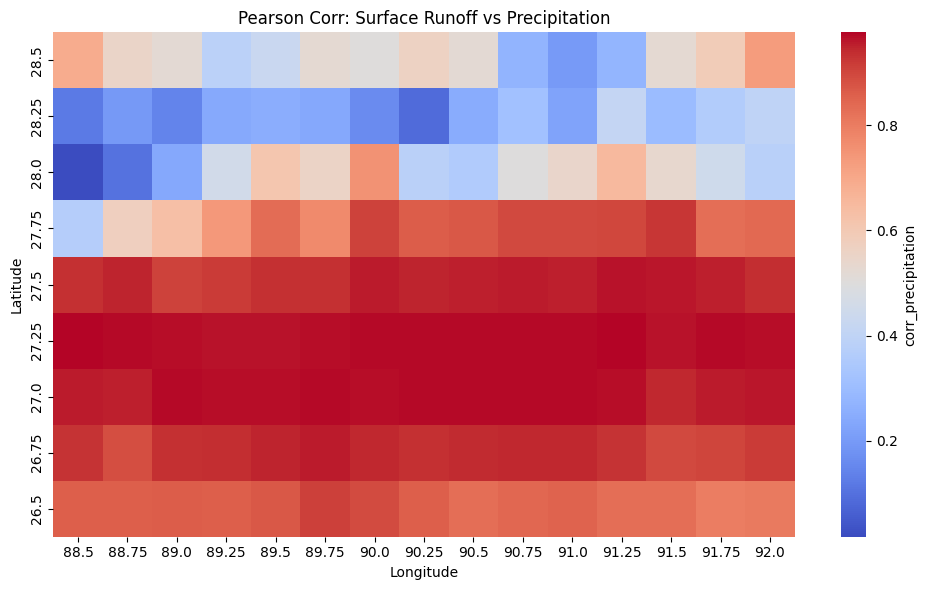

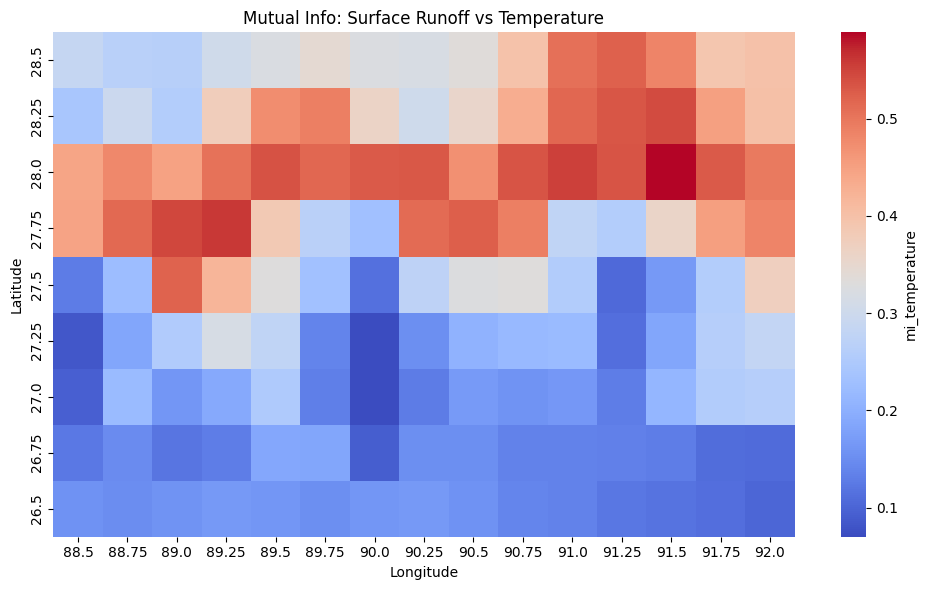

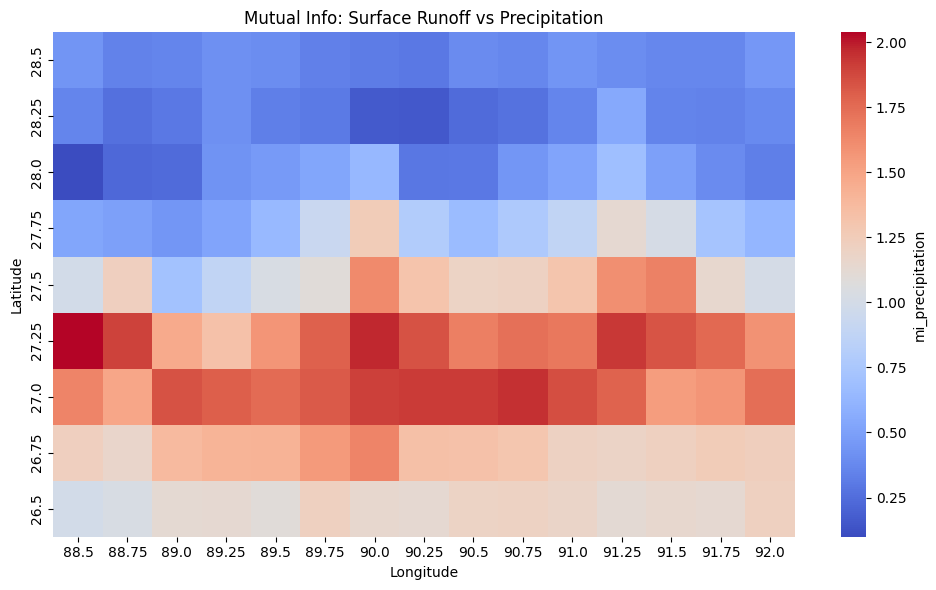

In [18]:
# Group by spatial unit (latitude, longitude)
grouped = merged_df.groupby(['latitude', 'longitude'])

# Store results
results = []

for (lat, lon), group in grouped:
    # Drop missing values just in case
    group = group[['temperature', 'precipitation', 'surface_runoff']].dropna()

    # Compute Pearson correlations
    corr_temp = group['temperature'].corr(group['surface_runoff'])
    corr_prec = group['precipitation'].corr(group['surface_runoff'])

    # Compute mutual information
    mi_temp = mutual_info_regression(group[['temperature']], group['surface_runoff'], random_state=0)[0]
    mi_prec = mutual_info_regression(group[['precipitation']], group['surface_runoff'], random_state=0)[0]

    results.append({
        'latitude': lat,
        'longitude': lon,
        'corr_temperature': corr_temp,
        'corr_precipitation': corr_prec,
        'mi_temperature': mi_temp,
        'mi_precipitation': mi_prec
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

def plot_heatmap(data, value_col, title):
    pivot = data.pivot(index='latitude', columns='longitude', values=value_col)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot.sort_index(ascending=False), cmap='coolwarm', cbar_kws={'label': value_col})
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

# Plot Pearson correlation heatmaps
plot_heatmap(results_df, 'corr_temperature', 'Pearson Corr: Surface Runoff vs Temperature')
plot_heatmap(results_df, 'corr_precipitation', 'Pearson Corr: Surface Runoff vs Precipitation')

# Plot Mutual Information heatmaps
plot_heatmap(results_df, 'mi_temperature', 'Mutual Info: Surface Runoff vs Temperature')
plot_heatmap(results_df, 'mi_precipitation', 'Mutual Info: Surface Runoff vs Precipitation')


### View distribution of surface_runoff

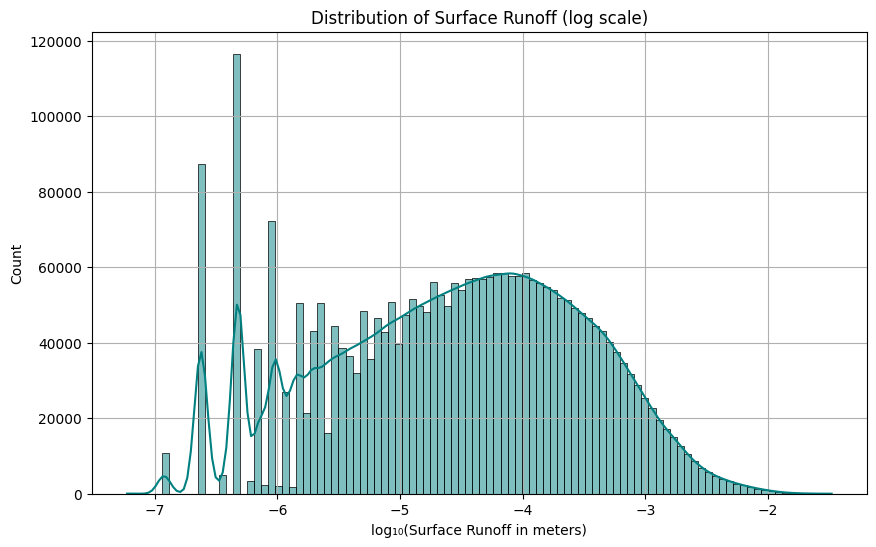

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out zero or negative values to avoid log(0)
runoff_nonzero = merged_df[merged_df["surface_runoff"] > 0]["surface_runoff"]

# Plot histogram of log10(runoff)
plt.figure(figsize=(10, 6))
sns.histplot(np.log10(runoff_nonzero), bins=100, kde=True, color="teal")
plt.xlabel("log₁₀(Surface Runoff in meters)")
plt.ylabel("Count")
plt.title("Distribution of Surface Runoff (log scale)")
plt.grid(True)
plt.show()


### Check out spatial map of surface runoff

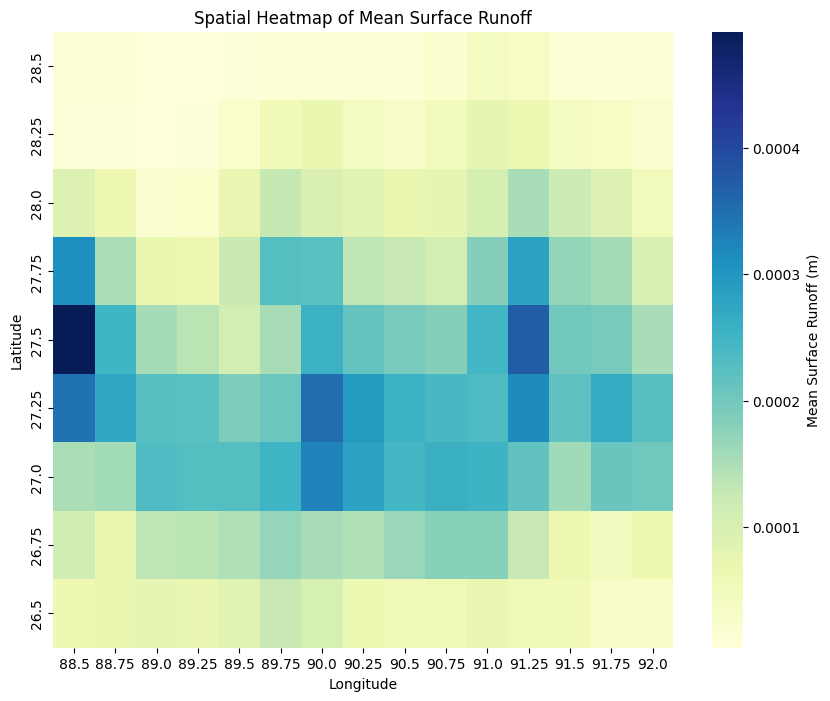

In [14]:
# Compute mean surface runoff for each lat-lon point
mean_runoff = (
    merged_df.groupby(["latitude", "longitude"])["surface_runoff"]
    .mean()
    .reset_index()
)

# Pivot to create 2D array (rows = lat, cols = lon)
heatmap_data = mean_runoff.pivot(index="latitude", columns="longitude", values="surface_runoff")

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data.sort_index(ascending=False),  # flip y-axis so north is up
    cmap="YlGnBu",
    cbar_kws={"label": "Mean Surface Runoff (m)"},
)
plt.title("Spatial Heatmap of Mean Surface Runoff")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


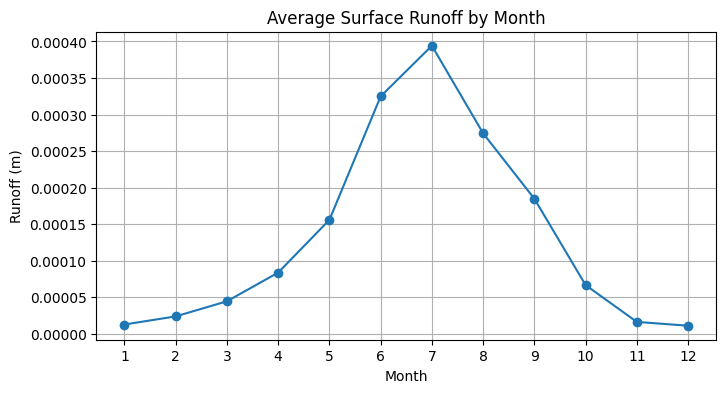

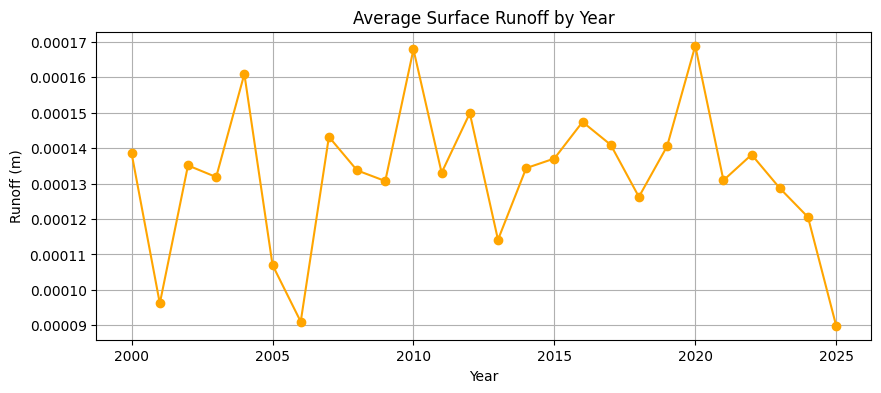

In [15]:
merged_df["year"] = merged_df["datetime"].dt.year
merged_df["month"] = merged_df["datetime"].dt.month

# Monthly mean across all years
monthly_avg = (
    merged_df.groupby("month")["surface_runoff"]
    .mean()
    .reset_index()
)

# Yearly mean across all months
yearly_avg = (
    merged_df.groupby("year")["surface_runoff"]
    .mean()
    .reset_index()
)


# Monthly
plt.figure(figsize=(8, 4))
plt.plot(monthly_avg["month"], monthly_avg["surface_runoff"], marker="o")
plt.title("Average Surface Runoff by Month")
plt.xlabel("Month")
plt.ylabel("Runoff (m)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

# Yearly
plt.figure(figsize=(10, 4))
plt.plot(yearly_avg["year"], yearly_avg["surface_runoff"], marker="o", color="orange")
plt.title("Average Surface Runoff by Year")
plt.xlabel("Year")
plt.ylabel("Runoff (m)")
plt.grid(True)
plt.show()
